# Stock Price Prediction using LSTM

## Introduction

This notebook demonstrates how to predict future stock prices using an LSTM model. 
We fetch stock data using Yahoo Finance, preprocess the data, train an LSTM network, 
and visualize predicted stock prices along with a simple buy/sell recommendation.


In [3]:
pip install yfinance matplotlib tensorflow scikit-learn pandas numpy

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     ----------------- ---------------------- 1.3/3.0 MB 4.5 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 5.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 1.8/331.9 MB 10.1 MB/s eta 0:00:33
   ---------------------------------------- 3.9/3

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.1 which is incompatible.


### Install & Import Libraries

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

### Fetch Stock Data

In [5]:
def fetch_stock_data(ticker, period='6mo'):
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)
    return df

# Example usage
ticker = "AAPL"
df = fetch_stock_data(ticker)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-05-15 00:00:00-04:00,210.506803,212.512590,209.099762,211.005753,45029500,0.0,0.0
2025-05-16 00:00:00-04:00,211.913842,212.123407,209.329287,210.816147,54737900,0.0,0.0
2025-05-19 00:00:00-04:00,207.473187,209.039881,203.830847,208.341354,46140500,0.0,0.0
2025-05-20 00:00:00-04:00,207.233696,208.032018,204.599243,206.425400,42496600,0.0,0.0
2025-05-21 00:00:00-04:00,204.738952,206.605018,200.288330,201.665421,59211800,0.0,0.0


**Explanation:** We fetch historical stock data (default 6 months) using Yahoo Finance.
In the place of Ticker Put Any ticker you want that is available in Yahoo

### Prepare Data for LSTM

In [6]:
def prepare_data(df, window=10):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Close']].values)

    X, y = [], []
    for i in range(window, len(scaled_data)):
        X.append(scaled_data[i - window:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

# Example usage
X, y, scaler = prepare_data(df)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (118, 10, 1) y shape: (118,)


**Explanation:** We scale the closing prices and prepare input-output pairs for the LSTM model using a sliding window.

### Build LSTM Model

In [7]:
def build_model(window=10):
    model = Sequential([
        Input(shape=(window, 1)),
        LSTM(50, return_sequences=True),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model(X.shape[1])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

**Explanation:** The LSTM model has 2 layers of LSTM and 2 dense layers. The output is a single value prediction for the next price.

### Train the Model

In [8]:
def train_model(X, y, epochs=10, batch_size=4):
    model = build_model(X.shape[1])
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Train
model = train_model(X, y)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0573
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063    


### Predict Future Prices

In [9]:
def predict_prices(df, window=10, future_days=5):
    X, y, scaler = prepare_data(df, window)
    if len(X) == 0:
        return [df['Close'].iloc[-1]] * future_days, scaler

    model = train_model(X, y)

    last_window = X[-1].reshape(1, window, 1)
    predicted_prices_scaled = []

    for _ in range(future_days):
        predicted_price_scaled = model.predict(last_window)[0,0]
        predicted_prices_scaled.append(predicted_price_scaled)
        last_window = np.roll(last_window, -1)
        last_window[0,-1,0] = predicted_price_scaled

    predicted_prices = scaler.inverse_transform(np.array(predicted_prices_scaled).reshape(-1,1)).flatten()
    predicted_prices = np.insert(predicted_prices, 0, df['Close'].iloc[-1])

    return predicted_prices, scaler

predicted_prices, scaler = predict_prices(df)
predicted_prices

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0665
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([272.41   , 275.56674, 276.25177, 277.07077, 277.90408, 278.76895],
      dtype=float32)

### Make Buy/Sell Decision

In [10]:
def make_decision(predicted_prices, current_price):
    return "Buy" if predicted_prices[-1] > current_price else "Sell"

current_price = df['Close'].iloc[-1]
decision = make_decision(predicted_prices, current_price)
print("Current Price:", current_price)
print("Decision:", decision)

Current Price: 272.4100036621094
Decision: Buy


### Plot Stock Data & Predictions

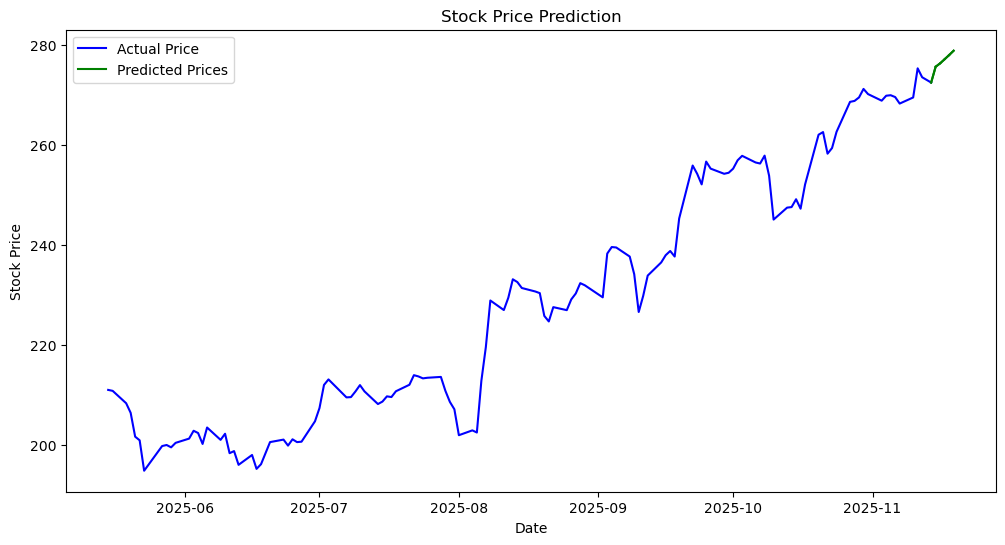

In [11]:
def plot_stock_data(df, predicted_prices, future_days=5):
    plt.figure(figsize=(12,6))
    future_dates = pd.date_range(df.index[-1], periods=future_days+1)

    plt.plot(df.index, df['Close'], label='Actual Price', color='blue')
    plt.plot(future_dates, predicted_prices, label='Predicted Prices',
             color='green' if predicted_prices[-1] > df['Close'].iloc[-1] else 'red')

    for i in range(1, len(predicted_prices)):
        plt.plot(future_dates[i-1:i+1], predicted_prices[i-1:i+1],
                 color='green' if predicted_prices[i]>=predicted_prices[i-1] else 'red')

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Price Prediction')
    plt.show()

plot_stock_data(df, predicted_prices)

### Full Recommendation Function

Enter Stock Ticker:  GOOG


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0670
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037   
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


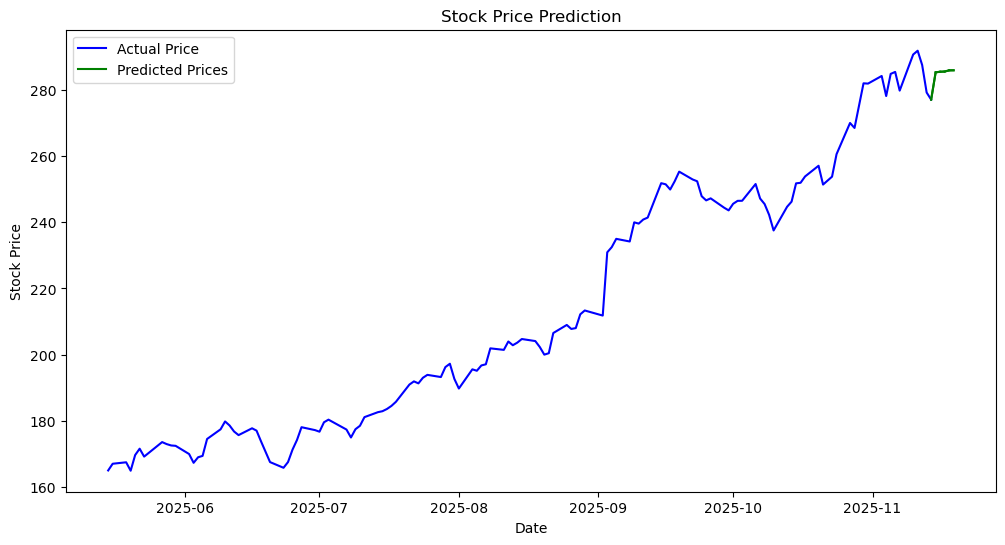

{'Ticker': 'GOOG', 'Current Price': 276.9800109863281, 'Predicted Prices': [276.9800109863281, 285.21405029296875, 285.3957214355469, 285.4538879394531, 285.8161315917969, 285.82879638671875], 'Recommendation': 'Buy'}


In [12]:
def stock_recommendation(ticker, future_days=5):
    df = fetch_stock_data(ticker)
    if df.empty:
        return "Invalid Ticker or No Data Available"

    current_price = df['Close'].iloc[-1]
    predicted_prices, _ = predict_prices(df, future_days=future_days)
    decision = make_decision(predicted_prices, current_price)

    plot_stock_data(df, predicted_prices, future_days)

    return {
        "Ticker": ticker,
        "Current Price": current_price,
        "Predicted Prices": predicted_prices.tolist(),
        "Recommendation": decision
    }

ticker = input("Enter Stock Ticker: ").strip().upper()
result = stock_recommendation(ticker)
print(result)